# Import libraries

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np

# Database creations using pytorch Dataset 

In [8]:
class ImageAuthenticityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def getInfo(self, idx):
        """
        Retrieves image Category, Challenge and prompt by index.
        
        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (category, challenge, prompt) where:
                category (str): The category of the image.
                challenge (str): The challenge of the image.
                prompt (str): The prompt of the image.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        category = self.data.iloc[idx, 5]
        challenge = self.data.iloc[idx, 6]
        prompt = self.data.iloc[idx, 7]

        return category, challenge, prompt
    def __getitem__(self, idx):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(os.getcwd(), self.data.iloc[idx, 3])  # image_path column
        image = Image.open(img_name).convert('RGB')
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels


# Definitions of the models

In [14]:
class AuthenticityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained VGG16
        vgg = vgg16(weights=VGG16_Weights.DEFAULT)
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in vgg.features.parameters():
                param.requires_grad = False
                
        # Extract features up to fc2
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.fc1 = vgg.classifier[:-1]  # Up to fc2 (4096 -> 128)
        
        # New regression head
        self.regression_head = nn.Sequential(
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)  # Predict quality and realness
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        features = self.fc1(x)
        predictions = self.regression_head(features)
        return predictions, features
    

## Setup section

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

ANNOTATIONS_FILE = 'Dataset/AIGCIQA2023/real_images_annotations.csv'

# Create the dataset
dataset = ImageAuthenticityDataset(csv_file=ANNOTATIONS_FILE, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Create a dictionary containing the data loaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}

# Models loading

In [ ]:
BASELINE_MODEL_PATH = 'Models/VGG-16_real_authenticity_finetuned.pth'

model = AuthenticityPredictor()
model.load_state_dict(torch.load(BASELINE_MODEL_PATH,weights_only=True))


AuthenticityPredictor(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, pad

Step 1: Feature Map Extraction
When an image travels through a neural network, each layer creates "activation maps" - essentially, each neuron lights up to different degrees based on what it sees in the image. These are like heatmaps showing what caught the network's attention.

In [60]:

class FeatureMapHook:
    """Hook to extract feature maps from neural network layers."""
    
    def __init__(self):
        self.feature_maps = []
    
    def __call__(self, module, input, output):
        # Detach from computation graph and move to CPU
        self.feature_maps.append(output.detach().cpu())

def get_feature_maps(model, dataloader, device):
    """
    Extracts the feature maps of a specific layer from a model.
    
    Args:
        model (nn.Module): The neural network model.
        dataloader (DataLoader): DataLoader for evaluation.
        device (str): Device to run the model on ('cuda' or 'cpu').
        
    Returns:
        np.ndarray: The feature maps as a numpy array with shape (240, num_features).
    """
    # Set model to evaluation mode
    model.eval()
    model.to(device)
    
    # Register a hook to extract feature maps
    hook = FeatureMapHook()
    
    hook_handle = model.features[28].register_forward_hook(hook)

    
    # Forward pass to extract feature maps from the dataloader
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            model(inputs)

    # Remove the hook
    hook_handle.remove()
    
    # Process the feature maps to get the desired shape
    all_features = []
    
    for batch_features in hook.feature_maps:
        # Add batch features to our collection
        all_features.append(batch_features)
    
    # Concatenate all batches and convert to numpy
    features_tensor = torch.cat(all_features, dim=0)
    
    # Ensure we have exactly the number of samples we expect in the dataloader 
    assert features_tensor.shape[0] == len(dataloader.dataset) 
    
    # Convert to numpy array
    features_array = features_tensor.numpy()
    
    return features_array



Step 2: Define Hollow Square Templates
Here, we're creating reference patterns to compare against:

These are hollow square outlines of different sizes (using 50%, 60%, 70%, 80%, and 90% of the feature map's dimensions)
Only the edges of these squares are "on" - the interior is empty
Each template is centered in the same space as our feature maps

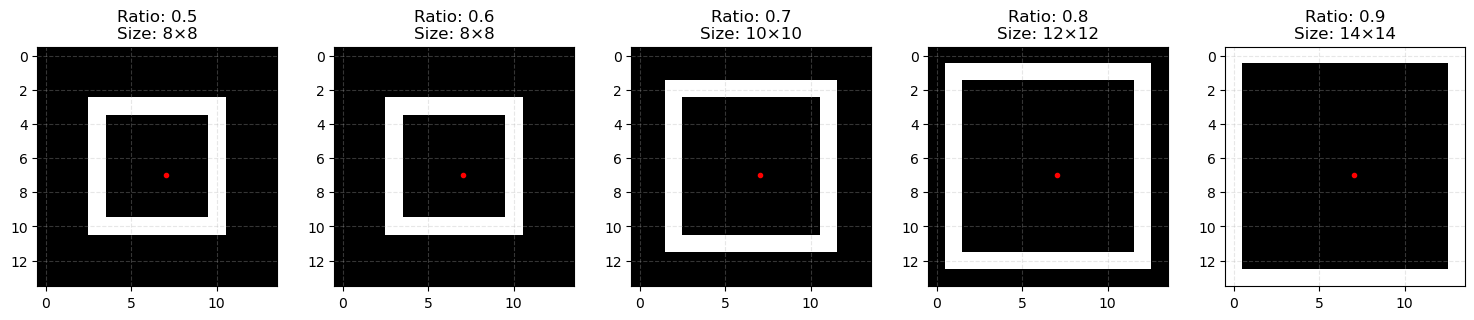

In [ ]:
import numpy as np

import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt

def create_hollow_square_templates_14x14():
    """
    Create hollow square templates specifically for 14×14 feature maps,
    ensuring perfect centering for all templates.
    
    Returns:
        Dictionary of templates with size ratios as keys
    """
    # Fixed feature map size
    feature_map_size = 14
    
    # These are the size ratios mentioned in the requirements
    size_ratios = [0.5, 0.6, 0.7, 0.8, 0.9]
    templates = {}
    
    # Pre-calculated exact positions for each ratio to ensure perfect centering
    # Format: (start_index, end_index) for a 14×14 grid
    positions = {
        0.5: (3, 10),   # 7×7 square (50% of 14)
        0.6: (3, 10),   # 8×8 square (rounded from 8.4×8.4)
        0.7: (2, 11),   # 10×10 square (rounded from 9.8×9.8)
        0.8: (1, 12),   # 12×12 square (rounded from 11.2×11.2)
        0.9: (0, 13)    # 14×14 square (rounded from 12.6×12.6)
    }
    
    for ratio in size_ratios:
        # Create empty template
        template = np.zeros((feature_map_size, feature_map_size))
        
        # Get pre-calculated positions
        start, end = positions[ratio]
        
        # Draw hollow square (only the edges)
        # Top edge
        template[start, start:end+1] = 1
        # Bottom edge
        template[end, start:end+1] = 1
        # Left edge
        template[start:end+1, start] = 1
        # Right edge
        template[start:end+1, end] = 1
        
        # Store template with its ratio
        templates[ratio] = template
    
    return templates

def visualize_templates(templates, feature_map_size=14):
    """
    Visualize all created templates to verify proper centering.
    """
    plt.figure(figsize=(15, 3))
    for i, (ratio, template) in enumerate(templates.items()):
        plt.subplot(1, len(templates), i+1)
        plt.imshow(template, cmap='gray')
        
        # Draw center point as a red dot
        center = feature_map_size / 2
        plt.plot(center, center, 'ro', markersize=3)
        
        # Calculate actual size of the square
        square_size = template.sum() / 4 + 1  # Divide by 4 sides and add 1 for corners
        
        plt.title(f"Ratio: {ratio}\nSize: {int(square_size)}×{int(square_size)}")
        plt.grid(True, linestyle='--', alpha=0.3)
        
    plt.tight_layout()
    plt.show()


templates = create_hollow_square_templates_14x14()
visualize_templates(templates)


Step 3: Match Templates to Feature Maps

For each feature map (i.e., each channel) in each image:
Compare the activation map to each of the square templates using a similarity measure (e.g., normalized cross-correlation or cosine similarity).
This yields one match score per square size.

In [ ]:
from scipy.stats import pearsonr

def compute_pearson_correlation(feature_map, template):
    """
    Compute Pearson correlation between a feature map and template.
    
    Args:
        feature_map: 2D numpy array of a single feature map
        template: 2D numpy array of template
        
    Returns:
        Pearson correlation coefficient
    """
    # Flatten arrays for correlation calculation
    feature_flat = feature_map.flatten()
    template_flat = template.flatten()
    
    # Calculate Pearson correlation
    correlation, _ = pearsonr(feature_flat, template_flat)
    
    # Handle NaN values (can happen if feature map is constant)
    if np.isnan(correlation):
        return 0.0
    
    return correlation
def match_templates_to_feature_maps(feature_maps, templates):
    """
    Match templates to feature maps and find best matches.
    
    Args:
        feature_maps: Tensor of shape [num_channels, height, width]
        templates: Dictionary of templates with size ratios as keys
        
    Returns:
        Dictionary with max scores and corresponding size ratios
    """
    num_channels = feature_maps.shape[0]
    results = {
        'max_scores': np.zeros(num_channels),
        'best_sizes': np.zeros(num_channels)
    }
    
    # Process each channel (feature map)
    for channel_idx in range(num_channels):
        # Get the feature map for this channel
        feature_map = feature_maps[channel_idx]
        
        max_score = -1.0
        best_size = 0.0
        
        # Compare with each template
        for size_ratio, template in templates.items():
            # Calculate correlation
            correlation = compute_pearson_correlation(feature_map, template)
            
            # Update if this is the best match so far
            if correlation > max_score:
                max_score = correlation
                best_size = size_ratio
        
        # Store results for this channel
        results['max_scores'][channel_idx] = max_score
        results['best_sizes'][channel_idx] = best_size
    
    return results

feature_maps = get_feature_maps(model, dataloaders['train'], device)

In [72]:
results = match_templates_to_feature_maps(feature_maps[0], templates)
print(results['max_scores'])
print(results['best_sizes'])

[ 1.89307168e-01  2.20686729e-02  3.67330814e-01  4.13486993e-01
  1.52722172e-01  4.23594971e-01  2.44682175e-01  5.01928883e-01
  1.50217870e-01  1.34340282e-01  1.57742361e-01  1.75609912e-01
  6.28157493e-02  6.32872953e-02  1.48609931e-01  4.05179613e-01
  5.26637853e-01  1.89060712e-01  4.38161731e-01  3.55888118e-01
  3.74002701e-01  1.79563570e-01  1.74161347e-01  4.31909871e-01
  4.54219792e-01  6.87384888e-02  3.54100905e-01  1.30353353e-01
  4.33260404e-01  2.64685141e-01  2.94441195e-01  3.19765194e-01
  3.73890658e-01  1.15301872e-01  5.60288831e-01  1.62645018e-01
  5.11120840e-01  2.88281214e-01  1.85910808e-01  3.97206611e-01
  1.69803190e-01  3.97917347e-01  5.10089588e-01  3.74044733e-01
  5.24719934e-01  2.88105666e-01  2.79859144e-01  1.56707333e-01
  3.89240305e-01  2.37056805e-01  2.30417634e-01  1.92228261e-01
  8.01380609e-02  1.41112283e-01  2.95080931e-01  1.26612941e-01
  2.33320067e-01  1.23597751e-01  2.25508178e-01  1.47839169e-01
  3.88363899e-01  1.12226

Step 4: Aggregate Results Across Images
Now analyze all this data to find patterns:

For each of the 512 spotlights, examine how well it matched squares across all images
Look for spotlights that consistently show high match scores (these might be "square detectors")
Look for spotlights with unusual score distributions - especially those that sometimes show very high matches (suggesting they only activate when squares are present)